<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Rizwan**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
# !pip3 -q install umap-learn
# !pip3 -q install hdbscan
# !pip3 -q install lpips
# !pip3 -q install torchmetrics
# !pip3 -q install optuna

In [2]:
# Import all the good stuff
import os
import torch
import optuna
import numpy as np
import matplotlib.pyplot as plt

## A few utility functions

In [3]:
from model import VeryTinyNerfModel
from image_encoder import ImageEncoder
from data_utils import load_tiny_nerf_data, load_nerf_data, get_focal_length
from nerf_utils import positional_encoding, get_minibatches, run_one_iter_of_tinynerf
from utils import select_frames_from_baseline, select_frames_from_clustering, calculate_lpips, calculate_ssim

In [4]:
experiment_data_type = "tiny_nerf"
#experiment_data_type = "nerf_synthetic"
nerf_test_subject = "ship" if experiment_data_type == "nerf_synthetic" else "lego" 
nerf_subjects_list = ['ship', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic']

tiny_data_path = "data/tiny_nerf_data.npz"
nerf_synthetic_path = "data/nerf_synthetic"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if experiment_data_type == "tiny_nerf":
    logs_path = f"logs/{experiment_data_type}"
else:
    logs_path = f"logs/{experiment_data_type}/{nerf_test_subject}"

## Get data

In [5]:
# Download sample data used in the official tiny_nerf example
if not os.path.exists(tiny_data_path):
    !wget -P data/ http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load up input images, poses, intrinsics, etc.

In [6]:
# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Height and width of each image
height, width = 100, 100

if experiment_data_type == "tiny_nerf":
    images, tform_cam2world, focal_length, testimgs, testposes = load_tiny_nerf_data(tiny_data_path, device)
else:
    images, train_poses, camera_angle_x = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_train.json')
    tform_cam2world = train_poses

    focal_length = get_focal_length(width, camera_angle_x)
    focal_length = torch.from_numpy(focal_length).to(device)

    # Hold one image out (for test).
    testimgs, testposes, _ = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_test.json', skip_images=20)

    testimgs = testimgs.to(device)
    testposes = torch.from_numpy(testposes).to(device)

    # # Map images to device
    images = images.to(device)
    tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

#### Display the image used for testing

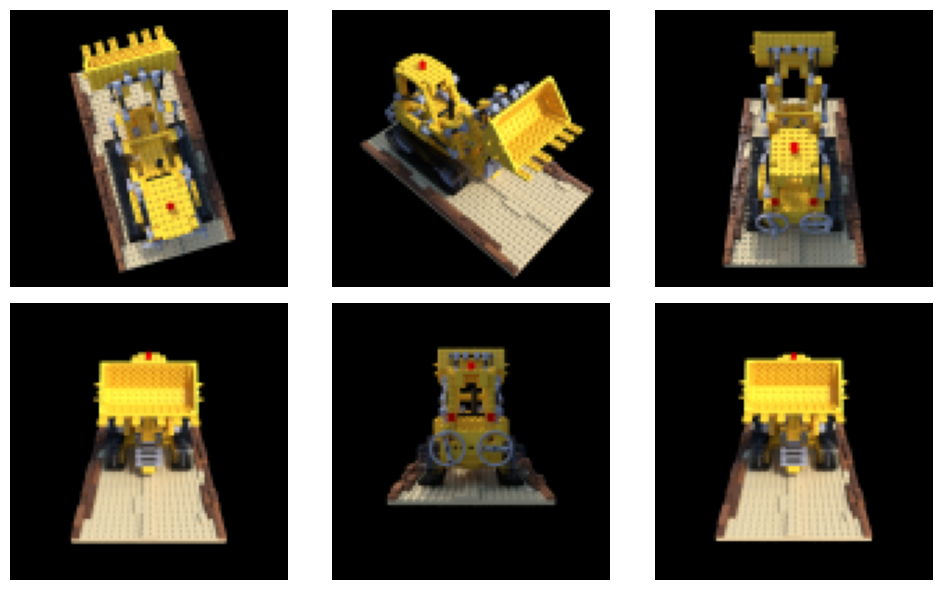

In [7]:
if experiment_data_type == "tiny_nerf":
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
else:
    fig, axs = plt.subplots(2, 5, figsize=(10, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), testimgs):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
if experiment_data_type == "tiny_nerf":
    plt.savefig(f"{logs_path}/test_images.png")
else:
    #create folder for nerf test subject
    if not os.path.exists(f"{logs_path}"):
        os.makedirs(f"{logs_path}")
    plt.savefig(f"{logs_path}/test_images_nerf.png")
plt.show()

In [8]:
psnr_vals_dict = {}
lpips_vals_dict = {}
ssim_vals_dict = {}

In [9]:
def objective(trial, images, embeddings, tform_cam2world):
    
    # tiny nerf parameters - not being changed
    lr = 5e-3
    num_iters = 200
    chunksize = 16384
    num_encoding_functions = 6
    depth_samples_per_ray = 32
    encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)

    # parameters fixed at the moment
    k = 10
    strategy = "fvs_distance"

    # Seed RNG, for repeatability
    seed = 9458
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # dimensionality reduction params to be tuned
    n_neighbors = trial.suggest_int("n_neighbors", 2, 50)
    min_dist = trial.suggest_float("min_dist", 0.01, 0.99)
    n_components = trial.suggest_int("n_components", 5, 50)

    # hdbscan clustering algorithm params to be tuned
    min_cluster_size = trial.suggest_int("min_cluster_size", 2, 10)
    min_samples = trial.suggest_int("min_samples", 2, 10)

    # initialize model and optimizer
    model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # make a string for the trial name based on the parameters
    trial_name = f"n_neighbors_{n_neighbors}_min_dist_{min_dist}_n_components_{n_components}_min_cluster_size_{min_cluster_size}_min_samples_{min_samples}"
    
    try:
        diverse_indices = select_frames_from_clustering(embeddings, tform_cam2world, focal_length, 
                                                    device=device, strategy=strategy, k=k, 
                                                    dim_red_method="umap", umap_params=[n_neighbors, min_dist, n_components],
                                                    min_cluster_size=min_cluster_size, min_samples=min_samples)
    except Exception as e:
        print('Skipping trial due to error: ', e)
        return 0
    
    training_images = images[diverse_indices]
    training_tforms = tform_cam2world[diverse_indices]
    psnr_vals, lpips_vals, ssim_vals = [], [], []

    for j in range(num_iters+1):

        # Randomly pick an image as the target.
        for training_img, training_pose in zip(training_images, training_tforms):
            
            # Run one iteration of TinyNeRF and get the rendered RGB image.
            rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                    training_pose, near_thresh,
                                                    far_thresh, depth_samples_per_ray,
                                                    encode, get_minibatches, chunksize, model)

            # Compute mean-squared error between the predicted and target images. Backprop!
            loss = torch.nn.functional.mse_loss(rgb_predicted, training_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_psnr, avg_lpips, avg_ssim = [], [], []
        with torch.no_grad():
            for testimg, testpose in zip(testimgs, testposes):
                avg_psnr = []
                rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                        testpose, near_thresh,
                                                        far_thresh, depth_samples_per_ray,
                                                        encode, get_minibatches, chunksize, model)
                loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
                psnr = -10. * torch.log10(loss)
                avg_psnr.append(psnr.item())
                lpips_loss = calculate_lpips(rgb_predicted, testimg, device)
                avg_lpips.append(lpips_loss)
                rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
                testimg_cpu = testimg.cpu().detach().numpy()
                ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
                avg_ssim.append(ssim_loss)
        
        psnr_avg = np.average(avg_psnr)
        trial.report(psnr_avg, j)
        psnr_vals.append(psnr_avg)
        lpips_vals.append(np.average(avg_lpips))
        ssim_vals.append(np.average(avg_ssim))

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    psnr_vals_dict[trial_name] = psnr_vals
    lpips_vals_dict[trial_name] = lpips_vals
    ssim_vals_dict[trial_name] = ssim_vals
    torch.save(model.state_dict(), f"{logs_path}/models/{trial_name}.pth")

    if not os.path.exists(f"{logs_path}/results"):
        os.makedirs(f"{logs_path}/results")
    np.save(f"{logs_path}/results/psnr_vals_dict_clustering.npy", psnr_vals_dict)
    np.save(f"{logs_path}/results/lpips_vals_dict_clustering.npy", lpips_vals_dict)
    np.save(f"{logs_path}/results/ssim_vals_dict_clustering.npy", ssim_vals_dict)
    
    return psnr_avg

In [10]:
image_encoder = ImageEncoder(device)
embeddings = image_encoder(images)

/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
study = optuna.create_study(study_name=f'{experiment_data_type}-{nerf_test_subject}', direction="maximize")
study.optimize(lambda trial: objective(trial, images, embeddings, tform_cam2world), n_trials=100, timeout=18000)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-29 01:04:56,410] A new study created in memory with name: tiny_nerf-lego
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/rizwan/Downloads/BDRP/utils.py:186: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400154748/work/torch/csrc/utils/tensor_new.cpp:264.)
  torch_cc_pos = torch.tensor(cluster_camera_pos)
/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400154748/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined

Skipping trial due to error:  The size of tensor a (0) must match the size of tensor b (3) at non-singleton dimension 0


[I 2024-01-29 02:22:33,351] Trial 17 pruned. 
[I 2024-01-29 02:22:51,966] Trial 18 pruned. 
[I 2024-01-29 02:23:10,540] Trial 19 pruned. 
[I 2024-01-29 02:23:33,537] Trial 20 pruned. 
[I 2024-01-29 02:23:57,248] Trial 21 pruned. 
[I 2024-01-29 02:24:16,612] Trial 22 pruned. 
[I 2024-01-29 02:24:40,367] Trial 23 pruned. 
[I 2024-01-29 02:24:59,375] Trial 24 pruned. 
[I 2024-01-29 02:25:48,854] Trial 25 pruned. 
[I 2024-01-29 02:26:08,130] Trial 26 pruned. 
[I 2024-01-29 02:26:31,324] Trial 27 pruned. 
[I 2024-01-29 02:26:50,865] Trial 28 pruned. 
[I 2024-01-29 02:27:16,420] Trial 29 pruned. 
[I 2024-01-29 02:28:26,767] Trial 30 pruned. 
[I 2024-01-29 02:28:54,492] Trial 31 pruned. 
[I 2024-01-29 02:29:12,093] Trial 32 pruned. 
[I 2024-01-29 02:29:30,625] Trial 33 pruned. 
[I 2024-01-29 02:29:57,171] Trial 34 pruned. 
[I 2024-01-29 02:30:19,715] Trial 35 pruned. 
[I 2024-01-29 02:30:42,495] Trial 36 pruned. 
[I 2024-01-29 02:31:52,996] Trial 37 pruned. 
[I 2024-01-29 02:32:20,358] Trial 

Skipping trial due to error:  The size of tensor a (0) must match the size of tensor b (3) at non-singleton dimension 0


[I 2024-01-29 02:41:22,625] Trial 52 pruned. 
[I 2024-01-29 02:41:40,713] Trial 53 pruned. 
[I 2024-01-29 02:42:16,633] Trial 54 pruned. 
[I 2024-01-29 02:43:32,546] Trial 55 pruned. 
[I 2024-01-29 02:57:43,551] Trial 56 finished with value: 22.532379150390625 and parameters: {'n_neighbors': 11, 'min_dist': 0.3901081026634076, 'n_components': 40, 'min_cluster_size': 6, 'min_samples': 2}. Best is trial 0 with value: 23.393653869628906.
[I 2024-01-29 02:59:02,152] Trial 57 pruned. 
[I 2024-01-29 02:59:20,421] Trial 58 pruned. 
[I 2024-01-29 02:59:47,033] Trial 59 pruned. 
[I 2024-01-29 03:00:05,161] Trial 60 pruned. 
[I 2024-01-29 03:00:22,949] Trial 61 pruned. 
[I 2024-01-29 03:01:17,047] Trial 62 pruned. 
[I 2024-01-29 03:01:44,775] Trial 63 pruned. 
[I 2024-01-29 03:02:34,756] Trial 64 pruned. 
[I 2024-01-29 03:03:10,734] Trial 65 pruned. 
[I 2024-01-29 03:04:25,430] Trial 66 pruned. 
[I 2024-01-29 03:04:43,761] Trial 67 pruned. 
[I 2024-01-29 03:05:01,665] Trial 68 pruned. 
[I 2024-0

Skipping trial due to error:  The size of tensor a (0) must match the size of tensor b (3) at non-singleton dimension 0


[I 2024-01-29 03:40:44,622] Trial 92 pruned. 
[I 2024-01-29 03:41:01,971] Trial 93 pruned. 
[I 2024-01-29 03:41:23,957] Trial 94 pruned. 
[I 2024-01-29 03:41:50,512] Trial 95 pruned. 
[I 2024-01-29 03:43:11,765] Trial 96 pruned. 
[I 2024-01-29 03:43:29,505] Trial 97 pruned. 
[I 2024-01-29 03:43:46,818] Trial 98 pruned. 
[I 2024-01-29 03:44:08,538] Trial 99 pruned. 


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  90
  Number of complete trials:  10
Best trial:
  Value:  23.393653869628906
  Params: 
    n_neighbors: 16
    min_dist: 0.9449656911534264
    n_components: 10
    min_cluster_size: 4
    min_samples: 2


In [42]:


def calculate_iou_3d(tform1, tform2, focal_length):
    boxes1 = get_box_vertices(tform1, focal_length)
    boxes2 = get_box_vertices(tform2, focal_length)
    vol, _ = box3d_overlap(boxes1.unsqueeze(0), boxes2.unsqueeze(0))
    return vol[0].item()


def maximal_coverage(tform_cam2world, focal_length, k):
    n = tform_cam2world.shape[0]
    
    # Initialize DP table
    DP = torch.zeros((n + 1, k + 1))
    
    # Build DP table
    for i in range(1, n + 1):
        for j in range(1, k + 1):
            DP[i][j] = float('inf')
            for l in range(i):
                DP[i][j] = min(DP[i][j], DP[l][j - 1] + calculate_iou(tform_cam2world, focal_length, i - 1, l))

    # Find the maximum coverage for k images
    # max_coverage = max(DP[n][k])

    # Traceback to find the selected indices
    selected_indices = []
    i, j = n, k
    while i > 0 and j > 0:
        if DP[i][j] != DP[i - 1][j]:
            selected_indices.append(i - 1)
            j -= 1
        i -= 1

    return DP, selected_indices